# Fast Gradient Sign Attack on some ImageNet samples on a Trained ResNet-18

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms

from src.data.ImageNet300 import ImageNet300Dataset
from src.utils.getimagenetclasses import get_classes
from src.attacks.attacks import FastGradientSign, ProjectedGradientDescent
from src.explainability.GradCam import GradCam
from src.utils.ImageDisplayerGradCam import ImageDisplayerGradCam

In [5]:
resnet_pretrained = models.resnet18(pretrained = True)
resnet_pretrained.eval()
pass

root_dir = 'Data/imagenetval300imgs/imagenet300'
xmllabeldir = "Data/imagenetval300imgs/val"
synsetfile = "Data/imagenetval300imgs/synset_words.txt"

image_transforms =  transforms.Compose([
          transforms.Resize((256,256)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


dataset = ImageNet300Dataset(root_dir, xmllabeldir, synsetfile, 300, image_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 8, shuffle = False)

classes = get_classes()

for samp in dataloader:
    break
loss_fn = nn.CrossEntropyLoss()

# Fast Gradient Sign Method

In [6]:
fgs = FastGradientSign(resnet_pretrained, loss_fn, return_logits=True)

## Attack


In [7]:
perturbed_images, org_pred, new_pred, outputs, new_outputs = fgs(samp['image'], samp['label'])

## How many miss classified


In [8]:
new_classification = (org_pred != new_pred)
torch.sum(new_classification).item(), new_classification

(6, tensor([False,  True,  True,  True,  True,  True, False,  True]))

In [9]:
missclassified = (org_pred != samp['label'])
torch.sum(missclassified).item(), missclassified

(2, tensor([ True, False,  True, False, False, False, False, False]))

## Choose a sample

In [10]:
samp_idx = 2

## Logits of most confident class:


In [11]:
nn.functional.softmax(outputs, dim = 1)[samp_idx].max(), nn.functional.softmax(outputs, dim = 1)[samp_idx].argmax().item()

(tensor(0.8261, grad_fn=<MaxBackward1>), 360)

## Logits of most confident class AFTER ATTACK


In [12]:
nn.functional.softmax(new_outputs, dim = 1)[samp_idx].max(), nn.functional.softmax(new_outputs, dim = 1)[samp_idx].argmax().item()

(tensor(0.2707, grad_fn=<MaxBackward1>), 611)

## Logits of the old predicted class AFTER ATTACK

In [13]:
nn.functional.softmax(new_outputs, dim = 1)[samp_idx][org_pred[samp_idx]]

tensor(0.0413, grad_fn=<SelectBackward0>)

## Grad-CAM:

In [14]:
target_layer = resnet_pretrained.layer4[-1].conv2
cam = GradCam(resnet_pretrained, target_layer, 10, multi_label = False)

classes = get_classes()

image_dispalyer = ImageDisplayerGradCam(resnet_pretrained, 
        cam, 
        classes,
        reshape = transforms.Resize((256,256)), 
        multi_label = False, 
        image_dir = 'image_net_dir',
        pdf = False)

### Perturbed

In [15]:
perturbed_sample = {'image':perturbed_images[samp_idx], 'label': samp['label'][samp_idx], 'filename':samp['filename'][samp_idx]}

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True class: sea lion 150
Predictions: jigsaw puzzle 611
Displaying true labels
Focus class: 150
image_net_dir/ILSVRC2012_val_00000033_heatmap_150.png


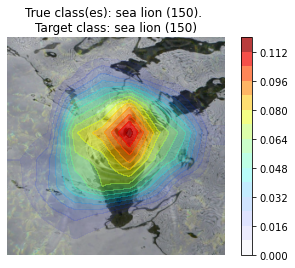

True class: sea lion 150
Predictions: jigsaw puzzle 611
Displaying predictions
Focus class: 611
image_net_dir/ILSVRC2012_val_00000033_heatmap_611.png


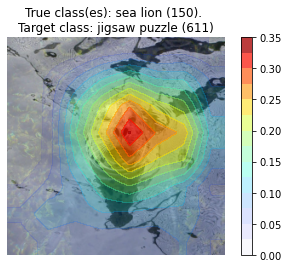

In [16]:
image_dispalyer.display_images(perturbed_sample, display_labels_or_predictions = True)
image_dispalyer.display_images(perturbed_sample, display_labels_or_predictions = False)

### Non-perturbed:

In [17]:
normal_sample = {'image':samp['image'][samp_idx], 'label': samp['label'][samp_idx], 'filename':samp['filename'][samp_idx]}

True class: sea lion 150
Predictions: otter 360
Displaying true labels
Focus class: 150
image_net_dir/ILSVRC2012_val_00000033_heatmap_150.png


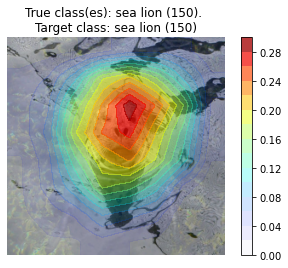

True class: sea lion 150
Predictions: otter 360
Displaying predictions
Focus class: 360
image_net_dir/ILSVRC2012_val_00000033_heatmap_360.png


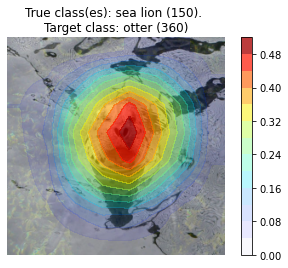

In [18]:
image_dispalyer.display_images(normal_sample, display_labels_or_predictions = True)
image_dispalyer.display_images(normal_sample, display_labels_or_predictions = False)

# Projected Gradient Descent Attack

In [19]:
pgd = ProjectedGradientDescent(resnet_pretrained, loss_fn, return_logits=True)

In [41]:
perturbed_images, original_preds, new_preds, outputs, new_outputs = pgd(samp['image'], samp['label'], random_start = True)

In [42]:
new_classification = (org_pred != new_pred)
torch.sum(new_classification).item(), new_classification

(6, tensor([False,  True,  True,  True,  True,  True, False,  True]))

In [43]:
missclassified = (org_pred != samp['label'])
torch.sum(missclassified).item(), missclassified

(2, tensor([ True, False,  True, False, False, False, False, False]))

In [44]:
samp_idx = 1

## Logits of most confident class:


In [45]:
nn.functional.softmax(outputs, dim = 1)[samp_idx].max(), nn.functional.softmax(outputs, dim = 1)[samp_idx].argmax().item()

(tensor(0.6511, device='cuda:0'), 826)

## Logits of most confident class AFTER ATTACK


In [46]:
nn.functional.softmax(new_outputs, dim = 1)[samp_idx].max(), nn.functional.softmax(new_outputs, dim = 1)[samp_idx].argmax().item()

(tensor(0.9998, device='cuda:0'), 531)

## Logits of the old predicted class AFTER ATTACK

In [47]:
nn.functional.softmax(new_outputs, dim = 1)[samp_idx][original_preds[samp_idx]]

tensor(2.7964e-05, device='cuda:0')

## Grad-CAM

In [48]:
target_layer = resnet_pretrained.layer4[-1].conv2
cam = GradCam(resnet_pretrained, target_layer, 10, multi_label = False)

classes = get_classes()

image_dispalyer = ImageDisplayerGradCam(resnet_pretrained, 
        cam, 
        classes,
        reshape = transforms.Resize((256,256)), 
        multi_label = False, 
        image_dir = 'image_net_dir',
        pdf = False)

## Perturbed

In [49]:
perturbed_sample = {'image':perturbed_images[samp_idx], 'label': samp['label'][samp_idx], 'filename':samp['filename'][samp_idx]}

True class: stopwatch, stop watch 826
Predictions: digital watch 531
Displaying true labels
Focus class: 826
image_net_dir/ILSVRC2012_val_00000290_heatmap_826.png


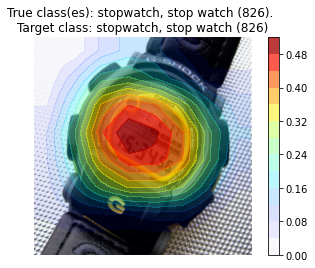

True class: stopwatch, stop watch 826
Predictions: digital watch 531
Displaying predictions
Focus class: 531
image_net_dir/ILSVRC2012_val_00000290_heatmap_531.png


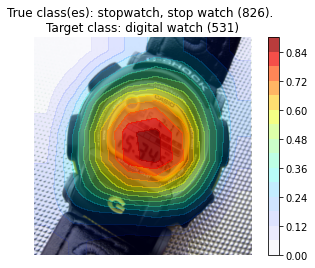

In [50]:
image_dispalyer.display_images(perturbed_sample, display_labels_or_predictions = True)
image_dispalyer.display_images(perturbed_sample, display_labels_or_predictions = False)

## Non-perturbed

In [51]:
normal_sample = {'image':samp['image'][samp_idx], 'label': samp['label'][samp_idx], 'filename':samp['filename'][samp_idx]}

True class: stopwatch, stop watch 826
Predictions: stopwatch, stop watch 826
Displaying true labels
Focus class: 826
image_net_dir/ILSVRC2012_val_00000290_heatmap_826.png


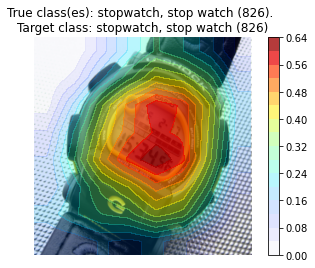

True class: stopwatch, stop watch 826
Predictions: stopwatch, stop watch 826
Displaying predictions
Focus class: 826
image_net_dir/ILSVRC2012_val_00000290_heatmap_826.png


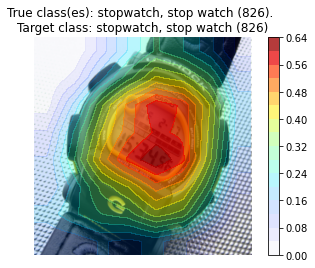

In [52]:
image_dispalyer.display_images(normal_sample, display_labels_or_predictions = True)
image_dispalyer.display_images(normal_sample, display_labels_or_predictions = False)